# BE Data Science - Copilote

### Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


### Chemins d'accès aux fichiers

In [2]:
TRAIN_PATH = "Data/train.csv"         
TEST_PATH = "Data/test.csv"
SAMPLE_PATH = "Data/sample_submission.csv"
OUTPUT_PATH = "Data/submission.csv"
RANDOM_STATE = 42

# 1. Accès et analyse des données
## 1.1. Ouverture des fichiers de train et test

In [3]:
def read_ds(path, is_train=True): 
    with open(path, 'r', encoding='utf-8') as f:
        lignes = [line.strip().split(',') for line in f]

    max_cols = max(len(l) for l in lignes)
    for l in lignes:
        l += [''] * (max_cols - len(l))

    if is_train:
        colonnes = ['util', 'navigateur'] + [f'col{i}' for i in range(3, max_cols + 1)]
    else:
        colonnes = ['navigateur'] + [f'col{i}' for i in range(2, max_cols + 1)]

    df = pd.DataFrame(lignes, columns=colonnes)
    return df


In [15]:
features_train = read_ds(TRAIN_PATH)
features_test = read_ds(TEST_PATH, is_train = False)
print(f"Shape de features_train : {features_train.shape}")
print(f"Shape de features_test : {features_test.shape}")


print("\n \nHead de features_train : ")
features_train.info()
features_train.describe()
features_test.head()


Shape de features_train : (3279, 14470)
Shape de features_test : (324, 7726)

 
Head de features_train : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Columns: 14470 entries, util to col14470
dtypes: object(14470)
memory usage: 362.0+ MB


,navigateur,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col7717,col7718,col7719,col7720,col7721,col7722,col7723,col7724,col7725,col7726
0,Microsoft Edge,Saisie dans un champ,t5,Saisie dans un champ,Exécution d'un bouton,t10,Exécution d'un bouton(fr.infologic.core.client...,t15,Exécution d'un bouton(fr.infologic.core.client...,Affichage d'une dialogue(fr.infologic.core.cli...,...,,,,,,,,,,
1,Firefox,Création d'un écran(infologic.core.accueil.Acc...,Sélection d’un onglet,Sélection d’un onglet,Sélection d’un onglet,Sélection d’un onglet,Sélection d'un flag,Sélection d’un onglet,Sélection d’un onglet,Exécution d'un bouton,...,,,,,,,,,,
2,Google Chrome,Clic long,Création d'un écran(infologic.core.gui.control...,t5,Création d'un écran,Clic long,Affichage d'une dialogue(infologic.orga.module...,Fermeture d'une dialogue,t10,Clic long,...,,,,,,,,,,
3,Google Chrome,Sélection d’un onglet(infologic.core.gui.contr...,t5,Exécution d'un bouton,Chainage,Affichage d'une dialogue,Exécution d'un bouton,Fermeture d'une dialogue,Création d'un écran(infologic.acti.modules.AT_...,Exécution d'un bouton<STD>,...,,,,,,,,,,
4,Firefox,Affichage d'une dialogue(infologic.acti.module...,t5,Saisie dans un champ,Fermeture d'une dialogue,t10,Raccourci,t10,Exécution d'un bouton,Fermeture d'une dialogue,...,,,,,,,,,,


## 1.2. Statistiques descriptives sur les données de train

In [5]:
def browsers_per_player(df):
    """
    Pour chaque utilisateur (en ligne), compter combien de fois il a utilisé chaque navigateur (en colonne)
    """
    # groupby + pivot pour obtenir un tableau utilisateurs × navigateurs
    table = df.groupby(['util', 'navigateur']).size().unstack(fill_value=0)
    return table  # <- très important pour que le décorateur affiche le tableau

browsers_per_player(features_train)

navigateur,Firefox,Google Chrome,Microsoft Edge,Opera
util,,,,
aho,0,10,0,0
ajo,13,0,0,0
akx,0,14,0,0
ald,0,15,0,0
ats,12,0,0,0
...,...,...,...,...
zqs,0,0,16,0
zro,13,0,0,0
zrx,0,0,12,0


In [6]:
def get_Y_stats(df):
    """
    Inspecte la distribution de la variable dépendante Y.
    """
    # Vérifier que la colonne 'util' existe
    if 'util' not in df.columns:
        raise ValueError("La colonne 'util' n'existe pas dans le DataFrame")

    # Calculer le nombre d'occurrences de chaque valeur de 'util'
    y_counts = df['util'].value_counts().to_frame(name='Nb_occurrences')

    # Calculer le pourcentage de chaque classe
    y_counts['%'] = (y_counts['Nb_occurrences'] / len(df) * 100).round(2)

    # Réinitialiser l'index pour avoir une colonne explicite 'util'
    y_counts = y_counts.reset_index().rename(columns={'index': 'util'})

    return y_counts

y_counts = get_Y_stats(features_train)
y_counts.head()


,util,Nb_occurrences,%
0,skm,75,2.29
1,slq,71,2.17
2,cjr,46,1.40
3,flj,42,1.28
4,hjs,37,1.13


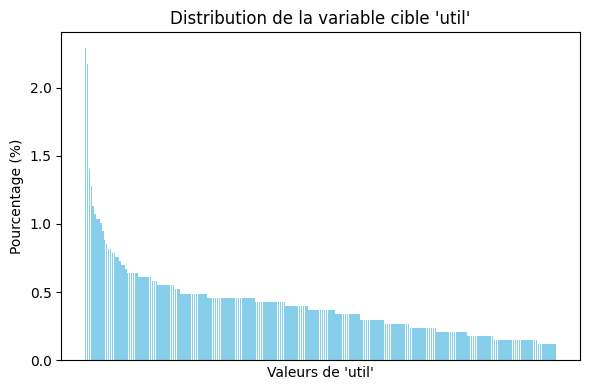

In [7]:
plt.figure(figsize=(6, 4))
plt.bar(y_counts['util'].astype(str), y_counts['%'], color='skyblue')
plt.title("Distribution de la variable cible 'util'")
plt.xlabel("Valeurs de 'util'")
plt.ylabel("Pourcentage (%)")
plt.xticks([])


plt.tight_layout()
plt.show()

# 2. Traitement des données brutes

## 2.1. Listing des différentes actions réalisables par les utilisateurs dans Copilote

In [8]:
# Crée la liste des actions filtrées uniques
def filter_action(value: str):
    for delim in ["(", "<", "$", "1"]:
        if delim in value:
            low_ind = value.index(delim)
            value = value[:low_ind]
    return value

def get_filtered_uniques(df):
    uniques = df.iloc[:, 2:].stack().unique()
    filtered = list(set([filter_action(u) for u in uniques if not str(u).startswith("t")]))
    return filtered

get_filtered_uniques(features_train)

['',
 'Action de table',
 "Ouverture d'un panel",
 "Sélection d'un écran",
 "Affichage d'une erreur",
 'Retour sur un écran',
 "Affichage d'une dialogue",
 'Filtrage / Tri',
 "Affichage d'une arborescence",
 'Sélection d’un onglet',
 "Raccourci dans l'édition de table",
 "Lancement d'un tableau de bord",
 "Affichage d'un toast",
 'Raccourci',
 "Clic sur une grille d'historique de recherche",
 'Entrée en saisie dans un formulaire',
 "Sélection d'un élément",
 'Fermeture de session',
 'Erreur système grave',
 "Lancement d'une stat",
 "Désélection d'un flag",
 'Saisie dans un champ',
 "Sélection d'un flag",
 'Chainage',
 "Dissimulation d'une arborescence",
 "Fermeture d'un panel",
 "Création d'un écran",
 "Lancement d'une action générique",
 'Double-clic',
 'Clic long',
 "Lancement d'une action infocentre",
 "Désélection d'un élément",
 "Exécution d'un bouton",
 'Clic sur une checkbox',
 "Démarrage serveur d'application Tomcat",
 "Fermeture d'une dialogue"]

## 2.2. Parsing des données en 3 colonnes : `Util` , `Navigateur`, `Actions` (cette dernière est une liste)

In [14]:
def parse_traces(df, is_train=True):
    """
    Extrait les actions non vides dans les colonnes colX.
    Garde les colonnes 'util' et 'navigateur' si elles existent déjà.
    Crée la colonne 'action' : liste des actions effectuées et des tXX.
    """
    df = df.copy()

    # Sélectionner uniquement les colonnes commençant par 'col'
    trace_cols = [c for c in df.columns if c.startswith('col')]

    # Créer la colonne 'actions' contenant la liste des valeurs non vides
    df['actions'] = df[trace_cols].apply(lambda x: [a for a in x if a != "" and not pd.isna(a)], axis=1)

    # Selon le mode, on garde les bonnes colonnes
    if is_train:
        return df[['util', 'navigateur', 'actions']]
    else:
        return df[['navigateur', 'actions']]


# Utilisation
train_df = parse_traces(features_train, is_train=True)
test_df = parse_traces(features_test, is_train=False)

print("Exemples (train) :")
print(test_df.head(3))


Exemples (train) :
       navigateur                                            actions
0  Microsoft Edge  [Saisie dans un champ, t5, Saisie dans un cham...
1         Firefox  [Création d'un écran(infologic.core.accueil.Ac...
2   Google Chrome  [Clic long, Création d'un écran(infologic.core...


## 2.3. Fonction d'analyse des `actions` et suivis temporels `tXX`pour chaque lignes du dataset dans la colonne `Actions`

In [ ]:
t_re = re.compile(r"^t(\d+)$")  # capture des tXX
def analyze_tokens(tokens):
    """
    tokens : liste de tokens tels qu'extraient depuis la ligne
    Retourne dict with:
       - actions_no_t : liste d'actions (sans tXX)
       - t_values     : liste d'entiers (valeurs des tXX) dans l'ordre d'apparition
       - windows      : liste counts d'actions par fenêtre temporelle
    """
    t_values = []
    windows = [0]  # commence par une fenêtre avant le premier tXX
    actions_no_t = []

    for tok in tokens:
        if tok is None:
            continue
        tok = tok.strip()
        if tok == "":
            continue
        m = t_re.match(tok)
        if m:
            # token temporel -> nouvelle fenêtre
            t_values.append(int(m.group(1)))
            # commence nouvelle fenêtre
            windows.append(0)
        else:
            # token action réel
            actions_no_t.append(tok)
            windows[-1] += 1

    # enlever la dernière fenêtre vide si le dernier token était un tXX
    #if len(windows) > 0 and windows[-1] == 0:
        #windows.pop()

    return {
        "actions_no_t": actions_no_t,
        "t_values": t_values,
        "windows": windows
    }

# df.loc[ligne, colonne]
valeur_test = train_df.loc[0, "actions"] 


["Création d'un écran(infologic.core.accueil.AccueilController)",
 "Affichage d'une dialogue",
 "Exécution d'un bouton",
 "Fermeture d'une dialogue",
 "Affichage d'une dialogue",
 "Exécution d'un bouton",
 "Fermeture d'une dialogue",
 "Création d'un écran(infologic.core.gui.controllers.nested.InputFormNestedWindow)",
 't5',
 "Exécution d'un bouton(MAINT)",
 "Affichage d'une dialogue",
 "Fermeture d'une dialogue",
 'Double-clic',
 "Exécution d'un bouton",
 "Lancement d'une stat(infologic.core.gui.controllers.nested.homeview.InputFormHomeView)",
 "Affichage d'un toast",
 "Lancement d'une stat(infologic.core.gui.controllers.nested.homeview.InputFormHomeView)",
 't10',
 "Affichage d'une dialogue(MAINT)",
 "Exécution d'un bouton",
 "Fermeture d'une dialogue",
 't15',
 'Double-clic',
 "Lancement d'une action générique",
 "Affichage d'une dialogue",
 "Affichage d'un toast",
 'Filtrage / Tri',
 "Exécution d'un bouton",
 "Fermeture d'une dialogue",
 "Création d'un écran",
 "Exécution d'un bouto

In [13]:
results=analyze_tokens(valeur_test)
results

{'actions_no_t': ["Création d'un écran(infologic.core.accueil.AccueilController)",
  "Affichage d'une dialogue",
  "Exécution d'un bouton",
  "Fermeture d'une dialogue",
  "Affichage d'une dialogue",
  "Exécution d'un bouton",
  "Fermeture d'une dialogue",
  "Création d'un écran(infologic.core.gui.controllers.nested.InputFormNestedWindow)",
  "Exécution d'un bouton(MAINT)",
  "Affichage d'une dialogue",
  "Fermeture d'une dialogue",
  'Double-clic',
  "Exécution d'un bouton",
  "Lancement d'une stat(infologic.core.gui.controllers.nested.homeview.InputFormHomeView)",
  "Affichage d'un toast",
  "Lancement d'une stat(infologic.core.gui.controllers.nested.homeview.InputFormHomeView)",
  "Affichage d'une dialogue(MAINT)",
  "Exécution d'un bouton",
  "Fermeture d'une dialogue",
  'Double-clic',
  "Lancement d'une action générique",
  "Affichage d'une dialogue",
  "Affichage d'un toast",
  'Filtrage / Tri',
  "Exécution d'un bouton",
  "Fermeture d'une dialogue",
  "Création d'un écran",
  

## 2.4. Créations de la table des features

In [12]:
import re
from collections import Counter

pattern_ecran = re.compile(r"\((.*?)\)")
pattern_conf_ecran = re.compile(r"<(.*?)>")
pattern_chaine = re.compile(r"\$(.*?)\$")


In [13]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

tqdm.pandas()

# --- Regex pour extraire les patterns ---
pattern_ecran = re.compile(r"\((.*?)\)")
pattern_conf_ecran = re.compile(r"<(.*?)>")
pattern_chaine = re.compile(r"\$(.*?)\$")

# --- Préparation des données de base ---
train_df = parse_traces(features_train, is_train=True)
test_df = parse_traces(features_test, is_train=False)

# --- Liste d’actions filtrées uniques ---
filtered_uniques = get_filtered_uniques(features_train)


# --- Fonction principale d'extraction de features ---
def extract_features(df, is_train=True):
    feats = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="extract_features"):
        actions = row["actions"]

        # --- Analyse temporelle ---
        token_info = analyze_tokens(actions)
        n_total_actions = len(token_info["actions_no_t"])
        duration = max(token_info["t_values"]) if token_info["t_values"] else 0
        avg_speed = (
            np.mean([c for c in token_info["windows"] if c > 0])
            if any(token_info["windows"])
            else 0.0
        )

        # --- Extraction regex sur la trace complète ---
        trace_text = ",".join(actions)
        ecran_matches = pattern_ecran.findall(trace_text)
        conf_matches = pattern_conf_ecran.findall(trace_text)
        chaine_matches = pattern_chaine.findall(trace_text)

        ecran = Counter(ecran_matches).most_common(1)[0][0] if ecran_matches else None
        conf_ecran = Counter(conf_matches).most_common(1)[0][0] if conf_matches else None
        chaine = Counter(chaine_matches).most_common(1)[0][0] if chaine_matches else None

        # --- Comptage des actions ---
        action_counts = {a: sum(1 for act in actions if a in act) for a in filtered_uniques}

        # --- Fréquences relatives ---
        action_freqs = {
            f"{a}_freq": (action_counts[a] / n_total_actions) if n_total_actions > 0 else 0.0
            for a in filtered_uniques
        }

        # --- Synthèse ---
        feat = {
            "navigateur": row.get("navigateur", None),
            "n_total_actions": n_total_actions,
            "duration": duration,
            "speed": round(avg_speed, 2),
            "n_ecran_actions": len(ecran_matches),
            "n_conf_actions": len(conf_matches),
            "n_chaine_actions": len(chaine_matches),
            "ecran": ecran,
            "conf_ecran": conf_ecran,
            "chaine": chaine,
        }

        feat.update(action_counts)
        feat.update(action_freqs)

        if is_train:
            feat["util"] = row.get("util", None)

        feats.append(feat)

    return pd.DataFrame(feats)


# --- Application aux deux jeux ---
train_feats = extract_features(train_df, is_train=True)
test_feats = extract_features(test_df, is_train=False)

print("Extraction terminée :")
train_feats.head()


extract_features: 100%|██████████| 324/324 [00:00<00:00, 1302.36it/s]

Extraction terminée :


,navigateur,n_total_actions,duration,speed,n_ecran_actions,n_conf_actions,n_chaine_actions,ecran,conf_ecran,chaine,...,Lancement d'une action infocentre_freq,Création d'un écran_freq,Lancement d'une stat_freq,Fermeture d'une dialogue_freq,Lancement d'un tableau de bord_freq,Affichage d'une arborescence_freq,Retour sur un écran_freq,Ouverture d'un panel_freq,Dissimulation d'une arborescence_freq,util
0,Firefox,2514,2905,4.09,191,7,899,MAINT,DEF_03/24,JCP,...,0.0,0.028640,0.033811,0.146778,0.0,0.000398,0.000796,0.000000,0.0,nuh
1,Google Chrome,90,230,1.91,8,4,43,infologic.orga.modules.OR_FICHIERTRAVAIL.Insta...,TELEM_MINIMAL,DB,...,0.0,0.033333,0.000000,0.022222,0.0,0.000000,0.000000,0.000000,0.0,muz
2,Microsoft Edge,608,750,3.82,94,35,52,DEMTEST,DEF_07/23,MES,...,0.0,0.059211,0.000000,0.062500,0.0,0.001645,0.006579,0.001645,0.0,zrx
3,Firefox,886,1445,2.82,249,9,203,MAINT,DEF_03/24,JCP,...,0.0,0.024831,0.113995,0.047404,0.0,0.000000,0.019187,0.000000,0.0,pou
4,Google Chrome,173,275,2.84,21,7,11,MAINT,INSTALLATEUR,GP,...,0.0,0.057803,0.000000,0.057803,0.0,0.000000,0.000000,0.000000,0.0,ald


In [14]:
test_feats.head(6)

,navigateur,n_total_actions,duration,speed,n_ecran_actions,n_conf_actions,n_chaine_actions,ecran,conf_ecran,chaine,...,Filtrage / Tri_freq,Lancement d'une action infocentre_freq,Création d'un écran_freq,Lancement d'une stat_freq,Fermeture d'une dialogue_freq,Lancement d'un tableau de bord_freq,Affichage d'une arborescence_freq,Retour sur un écran_freq,Ouverture d'un panel_freq,Dissimulation d'une arborescence_freq
0,Microsoft Edge,300,540,2.54,14,0,0,fr.infologic.core.client.modules.menu.homescre...,None,None,...,0.000000,0.0,0.000000,0.000000,0.153333,0.000000,0.0,0.000000,0.000000,0.0
1,Firefox,580,800,3.35,53,31,232,MAINT,MT_AppelN1,JCP,...,0.005172,0.0,0.051724,0.013793,0.093103,0.074138,0.0,0.001724,0.000000,0.0
2,Google Chrome,714,1225,2.90,13,8,0,infologic.orga.modules.OR_ANALYSE.saisie.Analy...,001,None,...,0.000000,0.0,0.009804,0.002801,0.046218,0.000000,0.0,0.000000,0.019608,0.0
3,Google Chrome,1062,1225,4.05,137,14,412,infologic.infoc.tableaubord.TableauBordController,DEF_03/24,SV,...,0.004708,0.0,0.053672,0.000000,0.093220,0.001883,0.0,0.047081,0.000000,0.0
4,Firefox,211,280,3.35,34,18,0,infologic.crm.modules.CRM_PLANNING.planning.Pl...,STD,None,...,0.000000,0.0,0.009479,0.000000,0.099526,0.000000,0.0,0.028436,0.000000,0.0
5,Google Chrome,443,465,4.43,34,15,22,infologic.core.FichiersController,DEF_07/23,GP,...,0.000000,0.0,0.024831,0.002257,0.092551,0.000000,0.0,0.013544,0.004515,0.0


In [15]:
# Colonnes catégoriques à encoder
categorical_cols = ["util", "conf_ecran", "navigateur", "ecran", "chaine"]

# Dictionnaire pour stocker les catégories originales
cat_mappings = {}

for col in categorical_cols:
    if col in train_feats.columns:
        cat = pd.Categorical(train_feats[col])
        cat_mappings[col] = cat.categories  # on sauvegarde les catégories
        train_feats[col] = cat.codes
        
        if col in test_feats.columns:
            test_feats[col] = pd.Categorical(test_feats[col], categories=cat.categories).codes


# Affichage
test_feats.head()

,navigateur,n_total_actions,duration,speed,n_ecran_actions,n_conf_actions,n_chaine_actions,ecran,conf_ecran,chaine,...,Filtrage / Tri_freq,Lancement d'une action infocentre_freq,Création d'un écran_freq,Lancement d'une stat_freq,Fermeture d'une dialogue_freq,Lancement d'un tableau de bord_freq,Affichage d'une arborescence_freq,Retour sur un écran_freq,Ouverture d'un panel_freq,Dissimulation d'une arborescence_freq
0,2,300,540,2.54,14,0,0,38,-1,-1,...,0.000000,0.0,0.000000,0.000000,0.153333,0.000000,0.0,0.000000,0.000000,0.0
1,0,580,800,3.35,53,31,232,13,79,23,...,0.005172,0.0,0.051724,0.013793,0.093103,0.074138,0.0,0.001724,0.000000,0.0
2,1,714,1225,2.90,13,8,0,100,0,-1,...,0.000000,0.0,0.009804,0.002801,0.046218,0.000000,0.0,0.000000,0.019608,0.0
3,1,1062,1225,4.05,137,14,412,99,48,49,...,0.004708,0.0,0.053672,0.000000,0.093220,0.001883,0.0,0.047081,0.000000,0.0
4,0,211,280,3.35,34,18,0,81,86,-1,...,0.000000,0.0,0.009479,0.000000,0.099526,0.000000,0.0,0.028436,0.000000,0.0


## 2.5. Analyse des features choisies

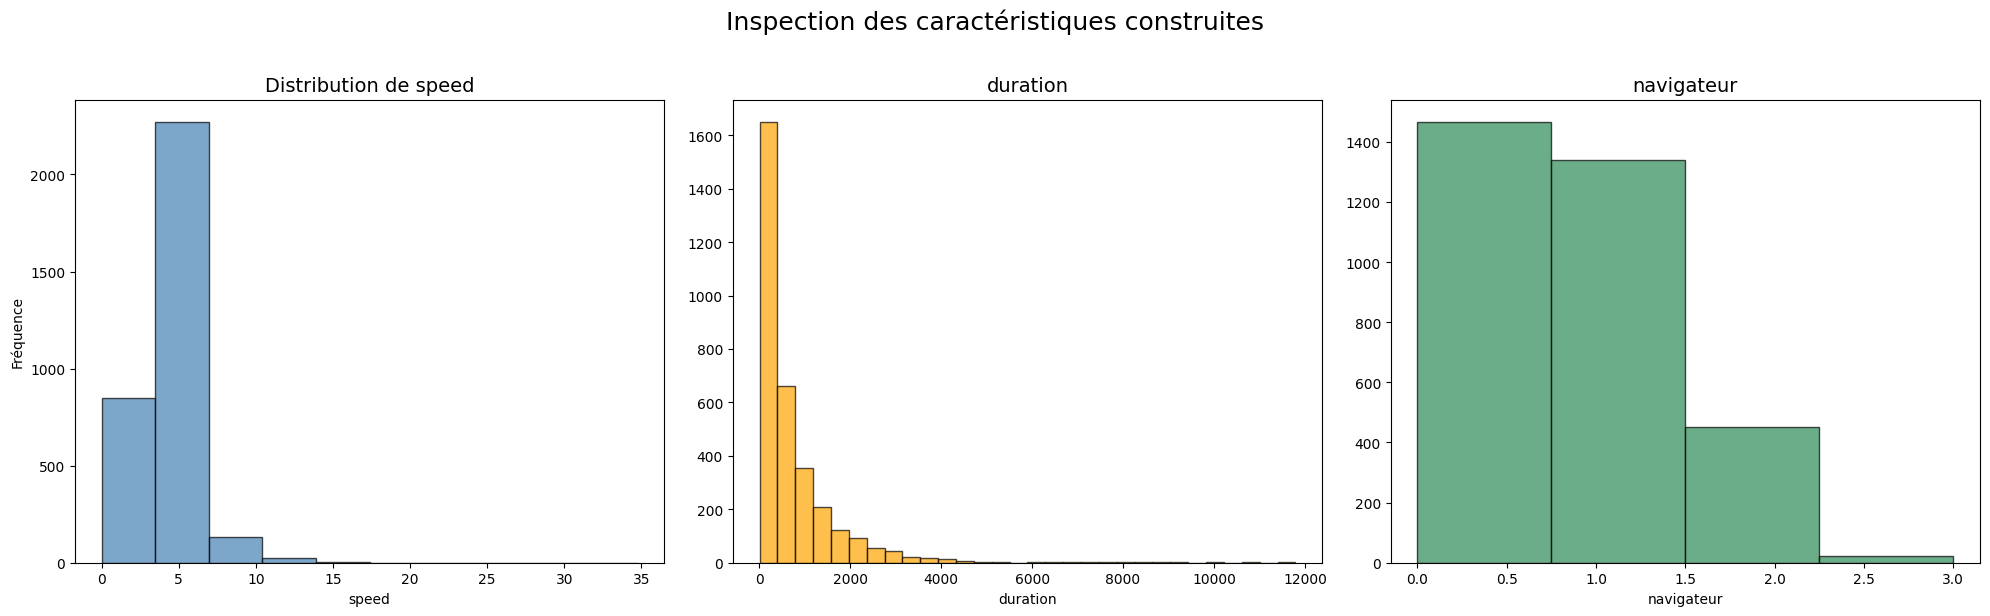

In [16]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(20, 6))

# --- 1. Distribution du nombre total d’actions ---
ax1.hist(train_feats["speed"], bins=10, color="steelblue", edgecolor="black", alpha=0.7)
ax1.set_title("Distribution de speed", fontsize=14)
ax1.set_xlabel("speed")
ax1.set_ylabel("Fréquence")

# --- 2. Répartition du ratio d’actions uniques ---
ax2.hist(train_feats["duration"], bins=30, color="orange", edgecolor="black", alpha=0.7)
ax2.set_title("duration", fontsize=14)
ax2.set_xlabel("duration")

# --- 3. Densité de fenêtres ---
ax3.hist(train_feats["navigateur"], bins=4, color="seagreen", edgecolor="black", alpha=0.7)
ax3.set_title("navigateur", fontsize=14)
ax3.set_xlabel("navigateur")

plt.suptitle("Inspection des caractéristiques construites", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


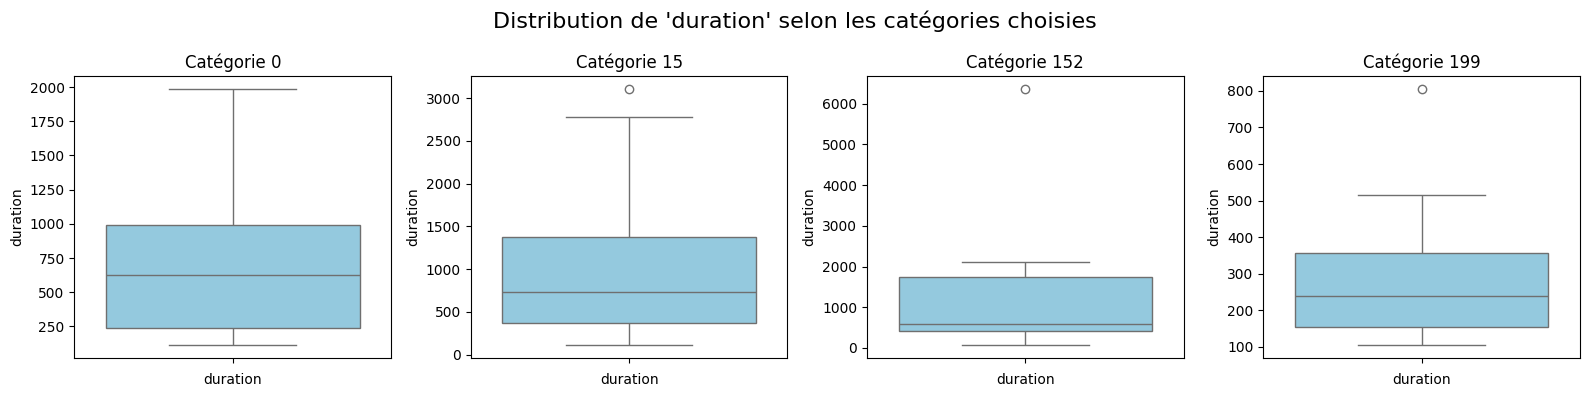

In [17]:
import seaborn as sns

def get_grid(n_items, n_row=1, figsize=(16, 4)):
    """Crée une grille de sous-graphiques dynamique."""
    n_col = int(np.ceil(n_items / n_row))
    fig, axs = plt.subplots(n_row, n_col, figsize=figsize)
    axs = np.array(axs).reshape(-1)  # aplatir même si une seule ligne
    return fig, axs[:n_items]

def plot_categories(categories, type_="box", feature="n_actions"):
    """
    Affiche la distribution d'une feature pour plusieurs catégories données.
    - categories : liste des valeurs de 'util_encoded' (ou 'util')
    - type_ : 'box' pour boxplot, 'hist' pour histogramme
    - feature : nom de la feature à visualiser
    """
    fig, axs = get_grid(len(categories), n_row=1, figsize=(4 * len(categories), 4))
    
    for i, cat in enumerate(categories):
        subset = train_feats[train_feats["util"] == cat]
        
        if subset.empty:
            axs[i].text(0.5, 0.5, f"Aucune donnée pour {cat}",
                        ha="center", va="center")
            axs[i].set_axis_off()
            continue

        if type_ == "box":
            sns.boxplot(y=subset[feature], ax=axs[i], color="skyblue")
        elif type_ == "hist":
            axs[i].hist(subset[feature], bins=20, color="steelblue", edgecolor="black", alpha=0.7)
        else:
            raise ValueError("type_ doit être 'box' ou 'hist'")

        axs[i].set_title(f"Catégorie {cat}", fontsize=12)
        axs[i].set_xlabel(feature)
    
    fig.suptitle(f"Distribution de '{feature}' selon les catégories choisies", fontsize=16)
    plt.tight_layout()
    plt.show()


categories = [0, 15, 152, 199]  # indices de classes arbitraires
plot_categories(categories, type_="box", feature="duration")


## 2.6. One Hot Encoding de `Navigateur` et normalisation des données

In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# Encodage OneHot sur le train
enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
nav_encoded_train = enc.fit_transform(train_feats[['navigateur']])
nav_cols = enc.get_feature_names_out(['navigateur'])
nav_df_train = pd.DataFrame(nav_encoded_train, columns=nav_cols, index=train_feats.index)
train_feats = train_feats.drop(columns=['navigateur'])
train_feats = pd.concat([train_feats, nav_df_train], axis=1)

# Même encodage sur le test
nav_encoded_test = enc.transform(test_feats[['navigateur']])
nav_df_test = pd.DataFrame(nav_encoded_test, columns=nav_cols, index=test_feats.index)
test_feats = pd.concat([test_feats.drop(columns=['navigateur']), nav_df_test], axis=1)

In [19]:
from sklearn.preprocessing import StandardScaler

# --- Colonnes catégoriques à encoder ---
categorical_cols = ["util", "conf_ecran", "navigateur", "ecran", "chaine"]

# --- Normalisation des colonnes numériques ---
exclude_cols = categorical_cols  # colonnes à exclure de la normalisation
num_cols = [c for c in train_feats.columns if c not in exclude_cols]

train_norm = train_feats.copy()
test_norm = test_feats.copy()

scaler = StandardScaler()
train_norm[num_cols] = scaler.fit_transform(train_norm[num_cols])
test_norm[num_cols] = scaler.transform(test_norm[num_cols])

# Affichage pour vérifier
train_norm.head()


,n_total_actions,duration,speed,n_ecran_actions,n_conf_actions,n_chaine_actions,ecran,conf_ecran,chaine,,...,Lancement d'un tableau de bord_freq,Affichage d'une arborescence_freq,Retour sur un écran_freq,Ouverture d'un panel_freq,Dissimulation d'une arborescence_freq,util,navigateur_0,navigateur_1,navigateur_2,navigateur_3
0,1.811279,2.140361,-0.177531,0.782345,-0.523272,3.012226,13,48,23,1.879126,...,-0.363929,-0.273723,-0.609958,-0.259948,-0.249211,130,1.112069,-0.830786,-0.399345,-0.084047
1,-0.598933,-0.518356,-1.497118,-0.607330,-0.587056,-0.257042,103,96,5,-0.589238,...,-0.363929,-0.302485,-0.631265,-0.259948,-0.249211,118,-0.899224,1.203679,-0.399345,-0.084047
2,-0.083880,-0.001522,-0.340966,0.045741,0.072045,-0.222669,3,49,28,-0.069496,...,-0.363929,-0.183555,-0.455063,0.138266,-0.249211,244,-0.899224,-0.830786,2.504099,-0.084047
3,0.192539,0.689248,-0.946281,1.222789,-0.480749,0.354036,13,48,23,0.287724,...,-0.363929,-0.302485,-0.117377,-0.259948,-0.249211,146,1.112069,-0.830786,-0.399345,-0.084047
4,-0.516405,-0.473630,-0.934175,-0.508610,-0.523272,-0.379258,13,67,20,-0.509215,...,-0.363929,-0.302485,-0.631265,-0.259948,-0.249211,3,-0.899224,1.203679,-0.399345,-0.084047


In [20]:
test_norm

,n_total_actions,duration,speed,n_ecran_actions,n_conf_actions,n_chaine_actions,ecran,conf_ecran,chaine,,...,Fermeture d'une dialogue_freq,Lancement d'un tableau de bord_freq,Affichage d'une arborescence_freq,Retour sur un écran_freq,Ouverture d'un panel_freq,Dissimulation d'une arborescence_freq,navigateur_0,navigateur_1,navigateur_2,navigateur_3
0,-0.390128,-0.210243,-1.115770,-0.561767,-0.672101,-0.421269,38,-1,-1,-0.357417,...,1.692280,-0.363929,-0.302485,-0.631265,-0.259948,-0.249211,-0.899224,-0.830786,2.504099,-0.084047
1,-0.111720,0.048174,-0.625464,-0.265607,-0.013001,0.464794,13,79,23,-0.081046,...,0.348003,2.040047,-0.302485,-0.585088,-0.259948,-0.249211,1.112069,-0.830786,-0.399345,-0.084047
2,0.021517,0.470587,-0.897856,-0.569361,-0.502011,-0.421269,100,0,-1,0.089727,...,-0.698427,-0.363929,-0.302485,-0.631265,4.487382,-0.249211,-0.899224,1.203679,-0.399345,-0.084047
3,0.367538,0.470587,-0.201744,0.372277,-0.374443,1.152257,99,48,49,0.390022,...,0.350612,-0.302864,-0.302485,0.629688,-0.259948,-0.249211,-0.899224,1.203679,-0.399345,-0.084047
4,-0.478622,-0.468661,-0.625464,-0.409890,-0.289398,-0.421269,81,86,-1,-0.476215,...,0.491350,-0.363929,-0.302485,0.130327,-0.259948,-0.249211,1.112069,-0.830786,-0.399345,-0.084047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,-0.391122,-0.344422,-0.619411,-0.561767,-0.438227,-0.421269,100,0,-1,-0.382166,...,-0.908878,-0.363929,0.423026,-0.631265,0.549797,4.735350,1.112069,-0.830786,-0.399345,-0.084047
320,-0.150499,-0.220182,0.191711,0.136868,1.113848,-0.325788,81,67,10,-0.161070,...,-0.987388,-0.363929,0.499467,-0.235218,-0.259948,0.174615,1.112069,-0.830786,-0.399345,-0.084047
321,-0.339418,-0.180426,-0.807059,-0.197262,-0.246875,-0.367800,69,42,0,-0.317817,...,-0.903349,-0.363929,1.139581,0.208077,-0.259948,2.363778,-0.899224,1.203679,-0.399345,-0.084047
322,-0.297657,-0.349391,0.052488,-0.409890,-0.140568,-0.039345,100,0,57,-0.305443,...,-0.139817,-0.363929,-0.302485,-0.426817,-0.259948,-0.249211,-0.899224,1.203679,-0.399345,-0.084047


Dimensions du jeu de données : (3279, 85)

Nombre d'outliers (> 4 écarts-types) par feature :
Désélection d'un élément_freq        65
Sélection d'un élément_freq          64
Affichage d'une arborescence_freq    53
Désélection d'un élément             53
Fermeture d'un panel_freq            52
                                     ..
Sélection d'un écran_freq             8
Erreur système grave_freq             7
Désélection d'un flag                 7
Affichage d'une dialogue_freq         3
Fermeture d'une dialogue_freq         2
Length: 79, dtype: int64

Total d'outliers détectés : 2221

Features à faible variance (potentiellement peu informatives) :
Désélection d'un flag               1.000305
Ouverture d'un panel                1.000305
navigateur_3                        1.000305
Dissimulation d'une arborescence    1.000305
Affichage d'un toast_freq           1.000305
dtype: float64


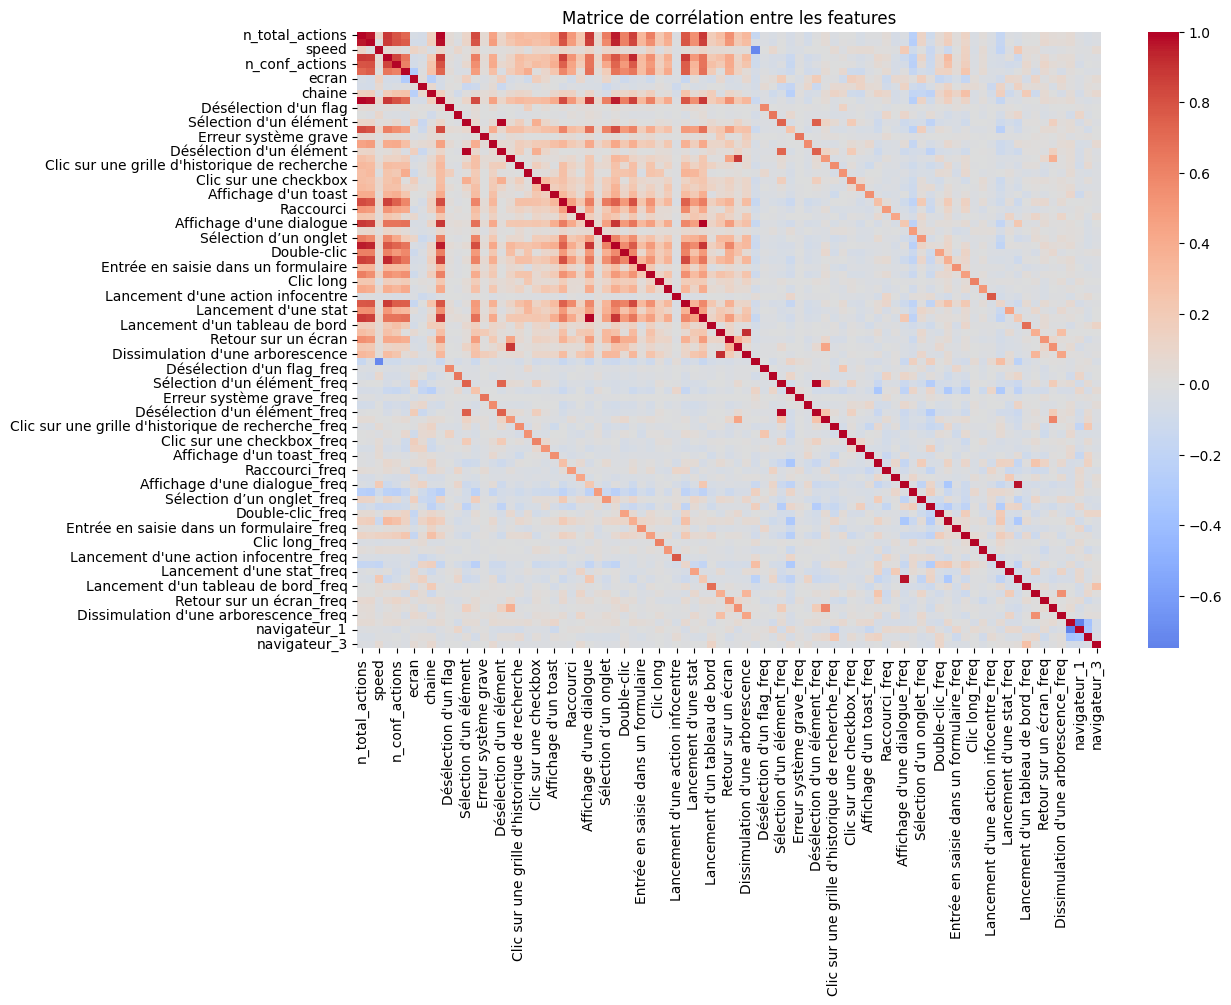


Paires de variables très corrélées (|corr| > 0.9) :
Affichage d'une dialogue       Fermeture d'une dialogue            0.999551
Sélection d'un élément         Désélection d'un élément            0.999374
n_total_actions                                                    0.998958
Sélection d'un élément_freq    Désélection d'un élément_freq       0.998073
duration                                                           0.976068
Affichage d'une dialogue_freq  Fermeture d'une dialogue_freq       0.967658
n_total_actions                duration                            0.965254
                               Exécution d'un bouton               0.956135
n_total_actions                Exécution d'un bouton               0.955574
duration                       Exécution d'un bouton               0.933033
n_ecran_actions                Sélection d'un écran                0.929949
Affichage d'une arborescence   Dissimulation d'une arborescence    0.917667
dtype: float64

Résumé :
- 79 featu

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# On part du DataFrame train_norm déjà normalisé
df = train_norm.copy()
df = df.drop(columns=["util"])

print("Dimensions du jeu de données :", df.shape)

# 1. Détection d'outliers avec le z-score
numeric_df = df.select_dtypes(include=[np.number])
z_scores = np.abs(stats.zscore(numeric_df, nan_policy='omit'))

# Comptage des outliers (> 4 écarts-types)
outlier_counts = (z_scores > 4).sum(axis=0)
outliers = pd.Series(outlier_counts, index=numeric_df.columns).sort_values(ascending=False)

print("\nNombre d'outliers (> 4 écarts-types) par feature :")
print(outliers[outliers > 0])

total_outliers = (z_scores > 4).sum()
print(f"\nTotal d'outliers détectés : {total_outliers}")

# 2. Analyse de la variance
low_variance = numeric_df.var().sort_values()
print("\nFeatures à faible variance (potentiellement peu informatives) :")
print(low_variance.head())

# 3. Corrélation entre variables numériques
corr_matrix = numeric_df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Matrice de corrélation entre les features")
plt.show()

# Identifier les couples de variables très corrélées
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)

strong_corr = corr_pairs[abs(corr_pairs) > 0.9]
print("\nPaires de variables très corrélées (|corr| > 0.9) :")
print(strong_corr)

# 4. Résumé général
print("\nRésumé :")
print(f"- {len(outliers[outliers > 0])} features contiennent des outliers.")
print(f"- {len(strong_corr)} paires de features sont très corrélées (>0.9).")
print(f"- {sum(low_variance < 0.01)} features ont une faible variance (<0.01).")


## 2.7. Catégorisation des différentes classes à identifier (Utilisateurs)

# 3. Mise en place des modèles

In [22]:
# Vérifier la variance des features
variances = train_norm.var().sort_values()
print("Features à variance nulle :")
print(variances[variances == 0])

# Vérifier s’il y a des colonnes constantes ou quasi constantes
low_var = variances[variances < 1e-5]
print(f"{len(low_var)} features quasi constantes :")
print(low_var)

# Corrélation avec la cible (approximation avec ANOVA F-test)
from sklearn.feature_selection import f_classif
import numpy as np

X = train_norm.drop(columns=["util"])
y = train_norm["util"]

f_vals, p_vals = f_classif(X, y)
importance = pd.DataFrame({
    "feature": X.columns,
    "F_value": f_vals,
    "p_value": p_vals
}).sort_values("F_value", ascending=False)

print("\nTop 10 features les plus discriminantes :")
print(importance.head(10))


Features à variance nulle :
Series([], dtype: float64)
0 features quasi constantes :
Series([], dtype: float64)

Top 10 features les plus discriminantes :
                                              feature       F_value  p_value
83                                       navigateur_2  4.443604e+16      0.0
84                                       navigateur_3  1.481201e+16      0.0
76                Lancement d'un tableau de bord_freq  3.644341e+02      0.0
55                           Sélection d'un flag_freq  3.062599e+02      0.0
68           Entrée en saisie dans un formulaire_freq  2.710562e+02      0.0
46                         Désélection d'un flag_freq  2.284101e+02      0.0
71                                Filtrage / Tri_freq  2.151953e+02      0.0
54  Clic sur une grille d'historique de recherche_...  1.372089e+02      0.0
78                           Retour sur un écran_freq  8.113770e+01      0.0
58                          Affichage d'un toast_freq  6.911836e+01      0.

In [23]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


# --- Séparation entre features et target ---
X = train_norm.drop(columns=["util"])
y = train_norm["util"]

# --- Split train / validation (80% / 20%) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Taille des jeux de données :")
print(f"Train : {X_train.shape[0]} échantillons")
print(f"Validation : {X_val.shape[0]} échantillons")




Taille des jeux de données :
Train : 2623 échantillons
Validation : 656 échantillons


In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
import numpy as np

# --- Définition des modèles à comparer ---
models = {
    "XGBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method="hist"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        max_depth=12,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced"
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "SVC": SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=7,
        n_jobs=-1
    ),
    "MLPClassifier": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=0.001,
        max_iter=300,
        random_state=RANDOM_STATE
    )
}

# --- Validation croisée simple pour comparer les modèles ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("\n Test de plusieurs modèles avec validation croisée...\n")

for name, model in tqdm(models.items(), desc="Modèles", total=len(models)):
    fold_scores = []

    for train_idx, val_idx in tqdm(cv.split(X, y), total=cv.get_n_splits(), desc=f"{name} CV", leave=False):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        f1 = f1_score(y_val, y_pred, average="macro")
        fold_scores.append(f1)

    mean_f1 = np.mean(fold_scores)
    std_f1 = np.std(fold_scores)
    results[name] = (mean_f1, std_f1)
    print(f"{name:20s} → F1 macro moyen : {mean_f1:.4f} ± {std_f1:.4f}")

# --- Meilleur modèle ---
best_model_name = max(results, key=lambda k: results[k][0])
print(f"\nMeilleur modèle avant optimisation : {best_model_name} ({results[best_model_name][0]:.4f})")

# --- Hyperparameter tuning pour RandomForest ou XGBoost ---
if best_model_name == "RandomForest":
    param_dist = {
        "n_estimators": [300, 500, 700],
        "max_depth": [8, 12, 16, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2", None]
    }
    base_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced")
elif best_model_name == "XGBoost":
    param_dist = {
        "n_estimators": [300, 400, 500],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
    base_model = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, tree_method="hist")

# --- Recherche aléatoire ---
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,           # nombre de combinaisons testées
    scoring="f1_macro",
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print(f"\nOptimisation des hyperparamètres pour {best_model_name}...")
search.fit(X, y)

print("\nMeilleurs hyperparamètres :")
print(search.best_params_)
print(f"Meilleur F1 macro CV : {search.best_score_:.4f}")

# --- Entraînement final avec meilleurs paramètres ---
best_model_final = search.best_estimator_
best_model_final.fit(X, y)
print(f"\nEntraînement final terminé pour {best_model_name}.")



 Test de plusieurs modèles avec validation croisée...



Modèles:  17%|█▋        | 1/6 [04:06<20:33, 246.79s/it]

XGBoost              → F1 macro moyen : 0.7241 ± 0.0174


Modèles:  33%|███▎      | 2/6 [04:13<07:02, 105.56s/it]

RandomForest         → F1 macro moyen : 0.8276 ± 0.0073


In [ ]:
# --- Préparation des features de test ---
X_test_final = test_norm.copy()

print("Dimensions du jeu de test :", X_test_final.shape)


Dimensions du jeu de test : (324, 86)


In [ ]:
# --- Prédictions sur les données de test ---
y_pred_test = best_model_final.predict(X_test_final)

# reconvertir les codes en labels

# Recréation de la Categorical pour 'util'
preds_test = pd.Categorical.from_codes(y_pred_test, categories=cat_mappings["util"])

df_subm = pd.DataFrame(preds_test)
df_subm = df_subm.rename_axis('RowId')
df_subm.rename(columns={0: 'prediction'}, inplace=True)
df_subm.index = df_subm.index + 1
df_subm

df_subm.to_csv('Data/submission.csv')